In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34971 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42649' processes=7 threads=14, memory=63.00 GiB>

In [3]:
#load in pressure data for each exp

In [4]:
def regrid_ACCESS(ds, var):
    #rename coords
    ds = ds.rename({"geolon_t": "lon", "geolat_t": "lat"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    #ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.lon[0, :], 'y': ds_out.lat[:, 0]})
    regridded = regridded.rename({'x': 'lon', 'y': 'lat'})
    return regridded

In [5]:
def regrid_ACCESS_atmos_u(ds, var):
    #rename coords
    ds = ds.rename({"lon_u": "longitude", "lat_v": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    #ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var])#.chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [6]:
def regrid_ACCESS_atmos(ds, var):
    #rename coords
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    #ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds[var])#.chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [7]:
def roll_lon2(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    return df

In [8]:
def roll_lon(df):
    df.coords['lon'] = (df.coords['lon'] + 360) % 360# - 180
    df = df.sortby(df.lon)
    return df

In [9]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(lat=slice(-5, 5),lon=slice(-170, -120)).mean(['lat', 'lon'])
     
def IOBM(DS):
    return ssta(DS).sel(lat=slice(-20, 20),lon=slice(40, 100)).mean(['lat', 'lon'])
def NINO34(DS):
    return ssta(DS).sel(lat=slice(-5, 5),lon=slice(-170, -120)).mean(['lat', 'lon'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(lat=slice(-10, 10),lon=slice(50, 70)).mean(['lat', 'lon'])
    SETIO = ssta(DS).sel(lat=slice(-10, 0),lon=slice(90, 110)).mean(['lat', 'lon'])
    return (WTIO-SETIO).drop('month')
def eio(DS):
    SETIO = ssta(DS).sel(lat=slice(-10, 0),lon=slice(90, 110)).mean(['lat', 'lon'])
    return (SETIO).drop('month')
def eio_1(DS):
    SETIO = (DS).sel(lat=slice(-10, 0),lon=slice(90, 110)).mean(['lat', 'lon'])
    return (SETIO)
def wio(DS):
    WTIO = ssta(DS).sel(lat=slice(-10, 10),lon=slice(50, 70)).mean(['lat', 'lon'])
    return (WTIO).drop('month')
def wio_1(DS):
    WTIO = (DS).sel(lat=slice(-10, 10),lon=slice(50, 70)).mean(['lat', 'lon'])
    return (WTIO)

In [10]:
def IOD_events(ds):
    #get the DMI timeseries in seaaons starting D(0)JF(1) etc
    QS = dmi(ds).resample(time='QS-DEC').mean(dim="time")
    #select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    #now use this to select all events and create da's of niod and piod event values
    lower,upper = SON.quantile([0.25, 0.75])
    nIOD = SON.where(SON <= lower.values).dropna(dim = "time")
    pIOD = SON.where(SON > upper.values).dropna(dim = "time")
    return nIOD, pIOD
def get_IOD_times(ds_sst, ds_var):
    nIOD, pIOD = IOD_events(ds_sst)
    #now get the times where the variable is in SON
    SON_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    #Now use nIOd and PIOD to get the times that we want
    nIOD_var = SON_var.where(SON_var.time == nIOD.time).dropna(dim = "time")
    pIOD_var = SON_var.where(SON_var.time == pIOD.time).dropna(dim = "time")
    return nIOD_var, pIOD_var

In [11]:
def get_IOD_times(ds_sst, ds_var):
    nIOD, pIOD = IOD_events(ds_sst)
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    #now get the ds_var groupbed by year for each season. 
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    # Initialize an empty list to store the subsets
    pos_list = []
    neg_list = []
    # Loop through each year group in ds_var and subset based on the specific years in both nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    # Combine the subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    return subset_ds_pos, subset_ds_neg

In [9]:
VC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_psl/VC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
OC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_psl/OC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
MC_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_psl/MC_pr*.nc",
                          use_cftime=True, chunks= {"time":240})
ctrl_psl = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_psl/ctrl_pr*.nc",
                          use_cftime=True, chunks= {"time":240})


In [10]:
#ctrl_psl = regrid_ACCESS_atmos(ctrl_psl, 'fld_s00i409')
ctrl_psl = ctrl_psl.fld_s00i409.compute()

In [11]:
#OC_psl = regrid_ACCESS_atmos(OC_psl, 'fld_s00i409')
OC_psl = OC_psl.fld_s00i409.compute()

In [12]:
#MC_psl = regrid_ACCESS_atmos(MC_psl, 'fld_s00i409')
MC_psl = MC_psl.fld_s00i409.compute()

In [38]:
#VC_psl = regrid_ACCESS_atmos(VC_psl, 'fld_s00i409')
VC_psl = VC_psl.fld_s00i409.compute()

In [ ]:
#load in ctrl walker variables

In [13]:
ctrl_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_u/ctrl_u*.nc",
                          use_cftime=True)

In [14]:
ctrl_u = ctrl_u.fld_s30i201.compute()

2023-11-12 19:34:48,935 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.83 GiB -- Worker memory limit: 9.00 GiB


In [ ]:
ctrl_w = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_w/ctrl_w*.nc",
                          use_cftime=True, chunks= {"time":240})
ctrl_w = ctrl_w.fld_s30i203.compute()

In [18]:
VC_w = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_w/VC_w*.nc",
                          use_cftime=True, chunks= {"time":240})
VC_w = VC_w.fld_s30i203.compute()

In [14]:
VC_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_u/VC_u*.nc",
                          use_cftime=True, chunks= {"time":240})

In [15]:
VC_u = VC_u.fld_s30i201.compute()

In [15]:
VC_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_u/VC_u*.nc",
                          use_cftime=True, chunks= {"time":240})
VC_u = VC_u.fld_s30i201.compute()

In [12]:
ctrl_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_om/ctrl_om*.nc",
                          use_cftime=True, chunks= {"time":240})
#ctrl_om = regrid_ACCESS_atmos_u(ctrl_om, 'fld_s30i208')
ctrl_om = ctrl_om.fld_s30i208.compute()

In [13]:
VC_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_om/VC_om*.nc",
                          use_cftime=True, chunks= {"time":240})
#VC_om = regrid_ACCESS_atmos_u(VC_om, 'fld_s30i208')
VC_om = VC_om.fld_s30i208.compute()

In [24]:
OC_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_om/OC_om*.nc",
                          use_cftime=True, chunks= {"time":240})
#OC_om = regrid_ACCESS_atmos_u(OC_om, 'fld_s30i208')
OC_om = OC_om.fld_s30i208.compute()

In [39]:
#load in SST

In [20]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
VC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
#ctrl_sst = ctrl_sst.sst.compute()
#VC_sst = VC_sst.sst.compute()

In [21]:
VC_sst = regrid_ACCESS(VC_sst, 'sst')
VC_sst = VC_sst.compute()

In [22]:
ctrl_sst = regrid_ACCESS(ctrl_sst, 'sst')
ctrl_sst = ctrl_sst.compute()

In [23]:
ctrl_sst = roll_lon(ctrl_sst)
VC_sst = roll_lon(VC_sst)


In [24]:
ctrl_sstc = ctrl_sst.groupby("time.month").mean("time")
VC_sstc = VC_sst.groupby("time.month").mean("time")

In [35]:
ctrl_sst = ctrl_sst.sel(time=slice("0951-01-01", "1150-12-31"))

In [36]:
#CONVERT TIMES FROM PORLEPTIC GREGORIAN TO GREOGIAN
ctrl_psl['time'] = ctrl_sst.time
ctrl_u['time'] = ctrl_sst.time
ctrl_om['time'] = ctrl_sst.time

In [41]:
VC_psl['time'] = VC_sst.sel(time=slice("0951-01-01", "1000-12-31")).time
VC_u['time'] = VC_sst.time
VC_om['time'] = VC_sst.time

In [20]:
#now create function to plot OM

In [18]:
#ctrl_wc = ctrl_w.groupby("time.month").mean("time")
#VC_wc = VC_w.groupby("time.month").mean("time")

ctrl_uc = ctrl_u.groupby("time.season").mean("time")
VC_uc = VC_u.groupby("time.season").mean("time")

In [14]:
ctrl_omc = ctrl_om.groupby("time.season").mean("time")
VC_omc = VC_om.groupby("time.season").mean("time")
#OC_omc = OC_om.groupby("time.month").mean("time")

In [15]:
ctrl_omc = ctrl_omc.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])
#ctrl_uc = ctrl_uc.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])
VC_omc = VC_omc.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])
#VC_uc = VC_uc.reindex(season=['MAM', 'JJA', 'SON', 'DJF'])

/jobfs/99454073.gadi-pbs/ipykernel_3641780/2533086756.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


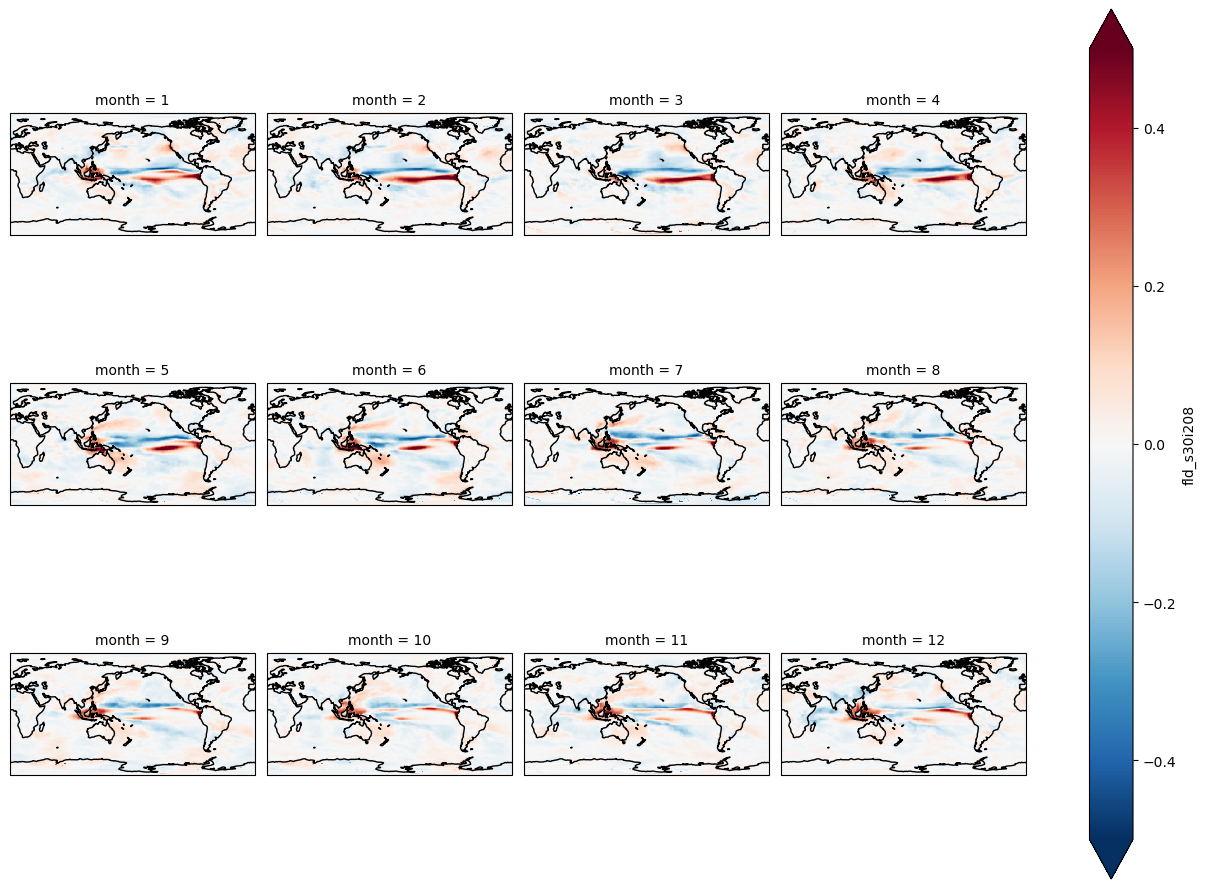

In [38]:
fg = (VC_omc.sum("pressure") - ctrl_omc.sum("pressure")).plot(col = "month", col_wrap = 4, 
                                                        transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)}, vmin = -0.5)
for ax in fg.axes.flat:
    ax.coastlines()

In [54]:
tes_var = (VC_sstc - ctrl_sstc).sel(lat=slice(-5,5)).mean("lat")

In [20]:
VC_sst_eq = VC_sstc.sel(lat=slice(-5,5)).mean("lat")
ctrl_sst_eq = ctrl_sstc.sel(lat=slice(-5,5)).mean("lat")

NameError: name 'VC_sstc' is not defined

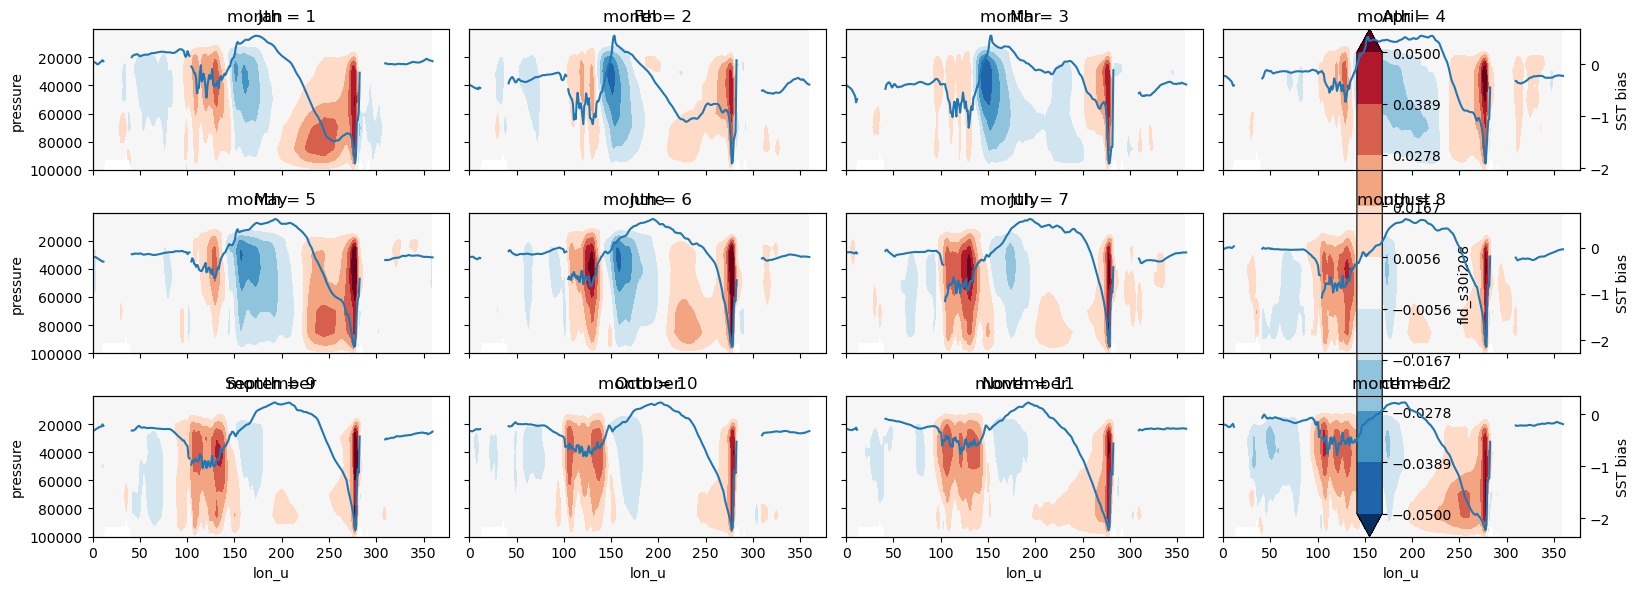

In [ ]:
fg = (VC_omc - ctrl_omc).sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "month", col_wrap = 2, levels = 10, vmin = -0.05, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
B_u_eq = VC_u_eq - ctrl_u_eq
i=0
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    #ax.contour(B_u_eq.lon_u.values, B_u_eq.pressure.values, (B_u_eq)[i].values,
    #           levels = 10,  colors = "k", linewidths = 0.5)
    ax2 = ax.twinx()
    ax2.plot(tes_var[i])
    if i in [0,1,2,4,5,6,8,9,10]:    
        ax2.set_yticks([])  # Hide the y-axis on the right
        ax2.spines['right'].set_visible(False)  # Hide the right spine of the axis
    else:
        ax2.set_ylabel("SST bias")
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    i=i+1
# Create a separate colorbar for the contour plot
#bar_ax = fg.cbar
#cbar_ax.set_position([0.92, 0.15, 0.02, 0.7])
plt.tight_layout()

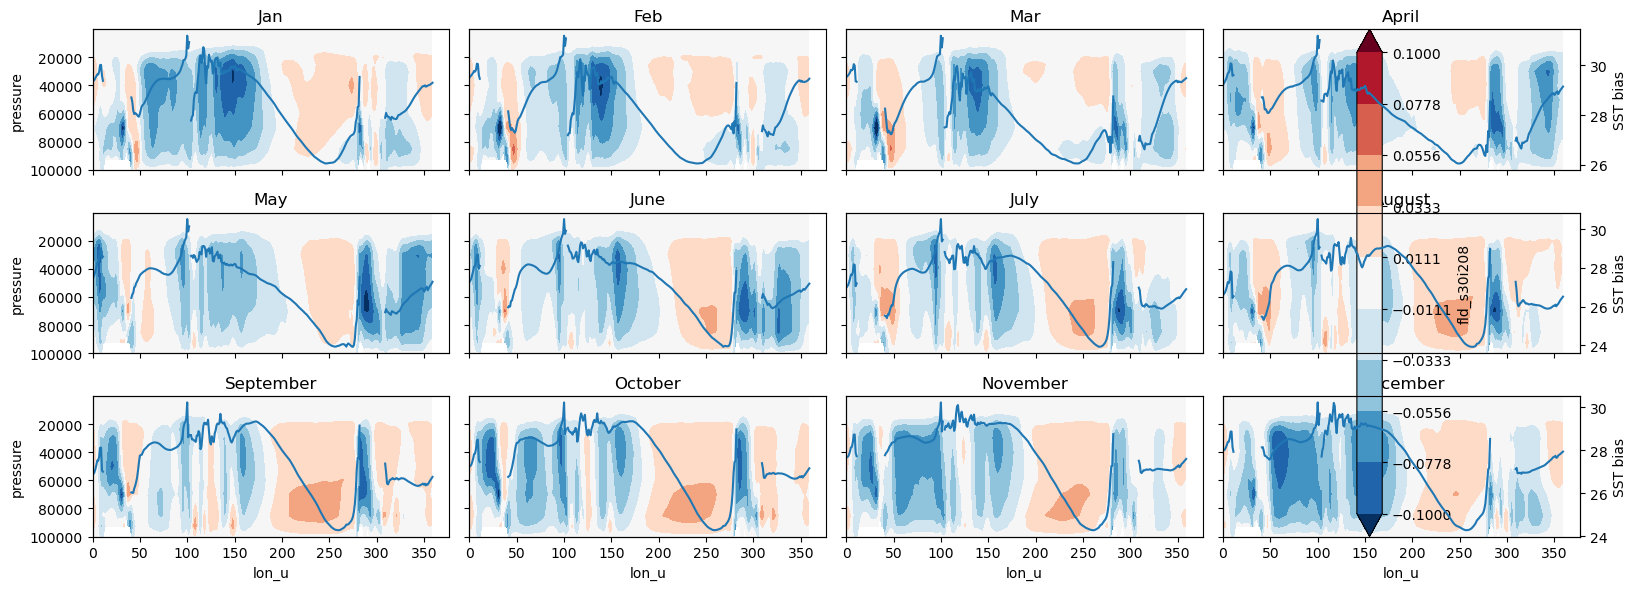

In [70]:
fg = (VC_omc).sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "month", col_wrap = 4, levels = 10, vmin = -0.1, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
B_u_eq = VC_u_eq - ctrl_u_eq
i=0
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    #ax.contour(B_u_eq.lon_u.values, B_u_eq.pressure.values, (B_u_eq)[i].values,
    #           levels = 10,  colors = "k", linewidths = 0.5)
    ax2 = ax.twinx()
    ax2.plot(VC_sst_eq[i])
    if i in [0,1,2,4,5,6,8,9,10]:    
        ax2.set_yticks([])  # Hide the y-axis on the right
        ax2.spines['right'].set_visible(False)  # Hide the right spine of the axis
    else:
        ax2.set_ylabel("SST bias")
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    i=i+1
# Create a separate colorbar for the contour plot
#bar_ax = fg.cbar
#cbar_ax.set_position([0.92, 0.15, 0.02, 0.7])

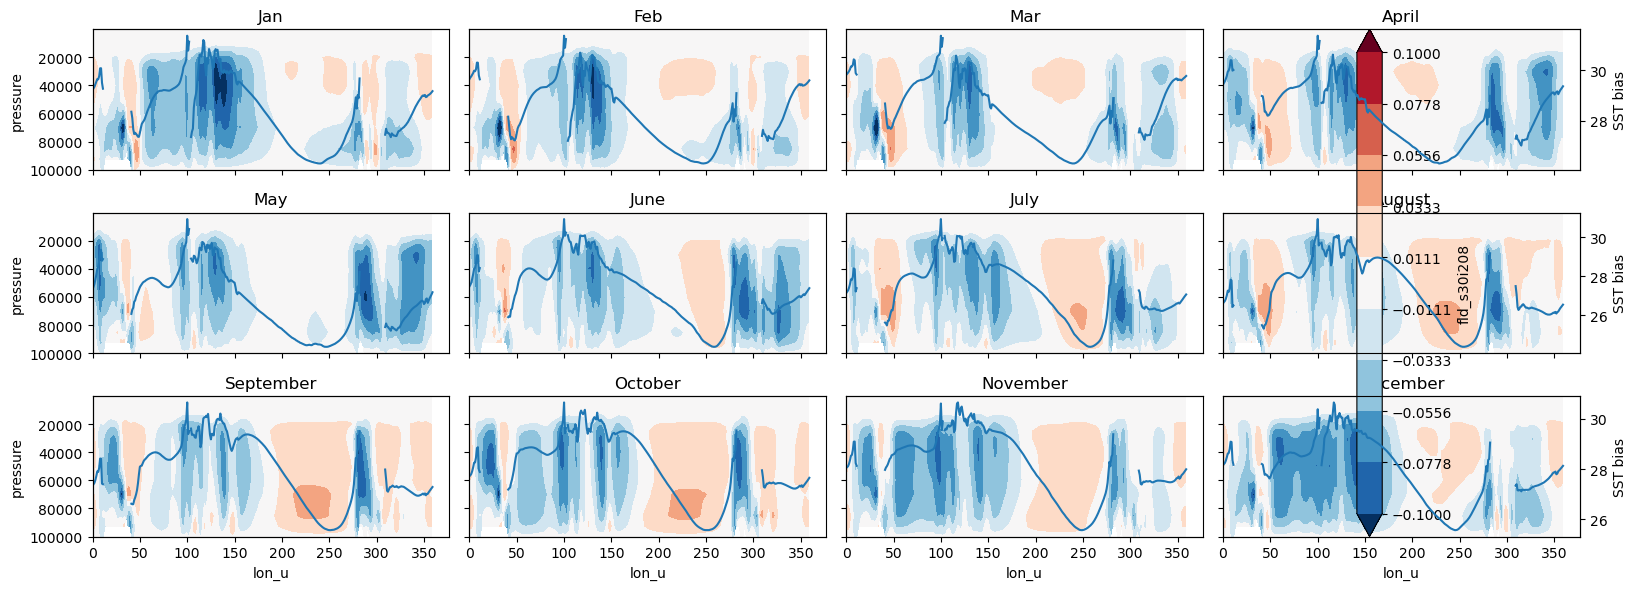

In [71]:
fg = (ctrl_omc).sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "month", col_wrap = 4, levels = 10, vmin = -0.1, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
B_u_eq = VC_u_eq - ctrl_u_eq
i=0
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    #ax.contour(B_u_eq.lon_u.values, B_u_eq.pressure.values, (B_u_eq)[i].values,
    #           levels = 10,  colors = "k", linewidths = 0.5)
    ax2 = ax.twinx()
    ax2.plot(ctrl_sst_eq[i])
    if i in [0,1,2,4,5,6,8,9,10]:    
        ax2.set_yticks([])  # Hide the y-axis on the right
        ax2.spines['right'].set_visible(False)  # Hide the right spine of the axis
    else:
        ax2.set_ylabel("SST bias")
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    i=i+1
# Create a separate colorbar for the contour plot
#bar_ax = fg.cbar
#cbar_ax.set_position([0.92, 0.15, 0.02, 0.7])

In [28]:
plt.contourf(ctrl_u_eq.lon_u.values, ctrl_u_eq.pressure.values, (ctrl_u_eq)[0].values,
               levels = 20, cmap = "RdBu_r", vmin = -50, vmax = 50)
plt.colorbar()

NameError: name 'ctrl_u_eq' is not defined

([<matplotlib.axis.XTick at 0x14723519e6d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

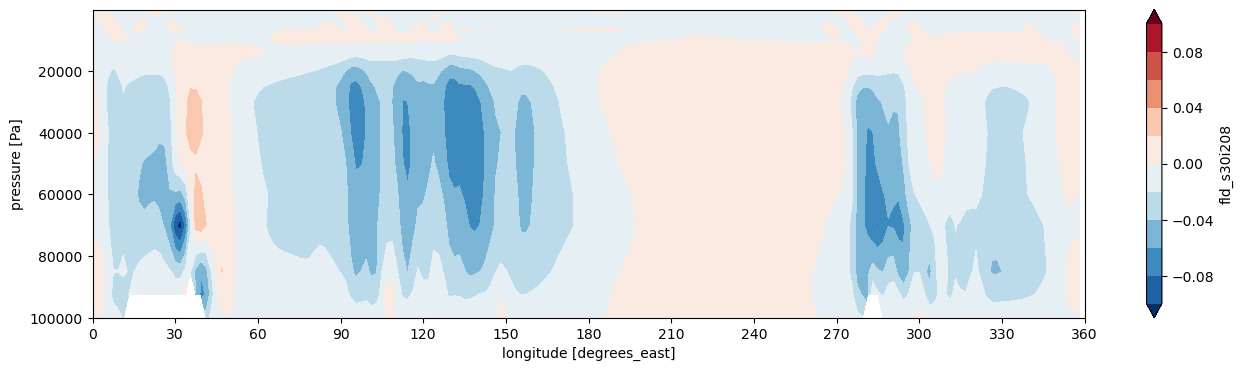

In [26]:
fg = ctrl_om.mean("time").sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    levels = 11, vmin = -0.1, cmap = "RdBu_r",
    figsize = (16,4), extend = "both", yincrease = False)
plt.xticks([0,30,60,90,120,150,180,210,240,270, 300, 330, 360])

#titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
#i=0
#ctrl_u_eq = ctrl_uc.sel(lat_v = slice(-5,5)).mean("lat_v")
#for ax,title in zip(fg.axs.flatten(),titles):
#    ax.set_title(title)
    #ax.contour(ctrl_u_eq.lon_u.values, ctrl_u_eq.pressure.values, (ctrl_u_eq)[i].values,
    #           levels = [-20,-15,-10,-5,0,5,10,15,20], colors = "k", linewidths = 0.5)

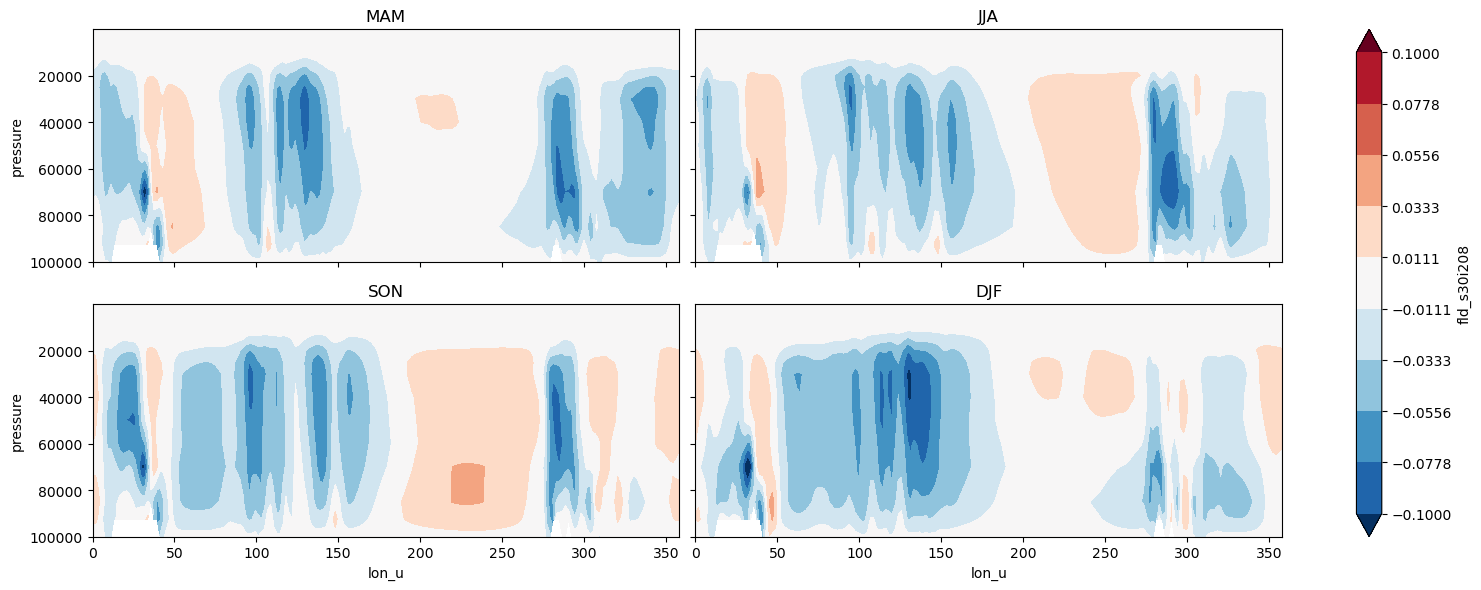

In [17]:
fg = ctrl_omc.sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "season", col_wrap = 2, levels = 10, vmin = -0.1, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["MAM", "JJA", "SON", "DJF"]
i=0
#ctrl_u_eq = ctrl_uc.sel(lat_v = slice(-5,5)).mean("lat_v")
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title)
    #ax.contour(ctrl_u_eq.lon_u.values, ctrl_u_eq.pressure.values, (ctrl_u_eq)[i].values,
    #           levels = [-20,-15,-10,-5,0,5,10,15,20], colors = "k", linewidths = 0.5)

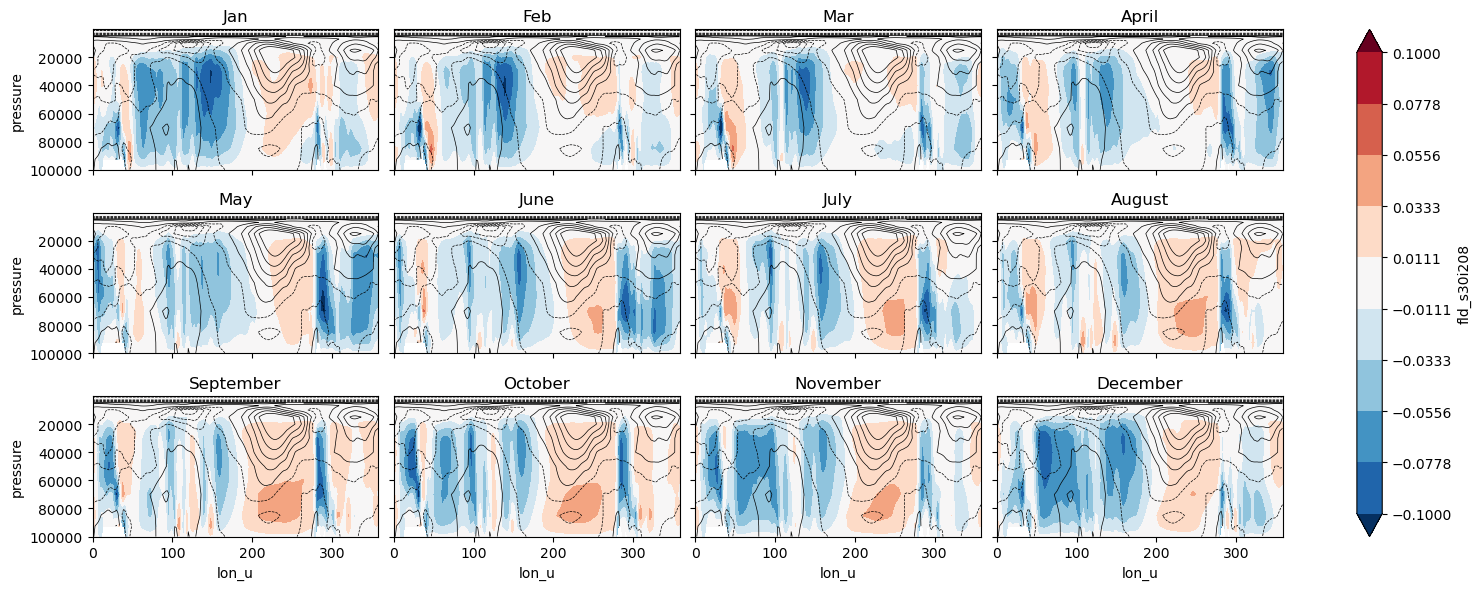

In [33]:
fg = VC_omc.sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "month", col_wrap = 4, levels = 10, vmin = -0.1, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i=0
VC_u_eq = VC_u.sel(lat_v = slice(-5,5)).mean("lat_v")
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    ax.contour(VC_u_eq.lon_u.values, VC_u_eq.pressure.values, (VC_u_eq)[i].values,
               levels = [-20,-15,-10,-5,0,5,10,15,20], colors = "k", linewidths = 0.5)

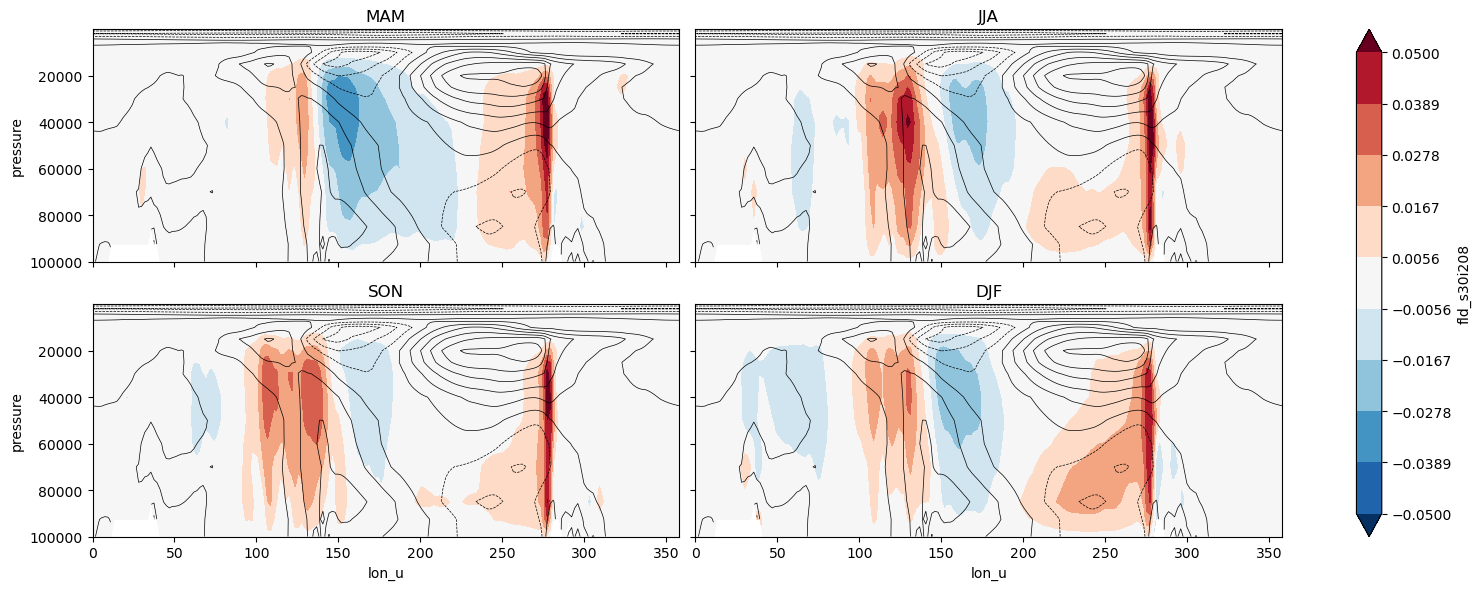

In [23]:
fg = ((VC_omc)-(ctrl_omc)).sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(
    col = "season", col_wrap = 2, levels = 10, vmin = -0.05, 
    figsize = (16,6), extend = "both", yincrease = False)
titles =["MAM", "JJA", "SON", "DJF"]
i=0
VC_u_eq = VC_uc.sel(lat_v = slice(-5,5)).mean("lat_v")

B_u_eq = VC_u_eq - ctrl_u_eq
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    ax.contour(B_u_eq.lon_u.values, B_u_eq.pressure.values, (B_u_eq)[i].values,
               levels = 10,  colors = "k", linewidths = 0.5)

In [49]:
ctrl_om_p, ctrl_om_n = get_IOD_times(ctrl_sst, ctrl_om)

In [51]:
VC_om_p, VC_om_n = get_IOD_times(VC_sst, VC_om)

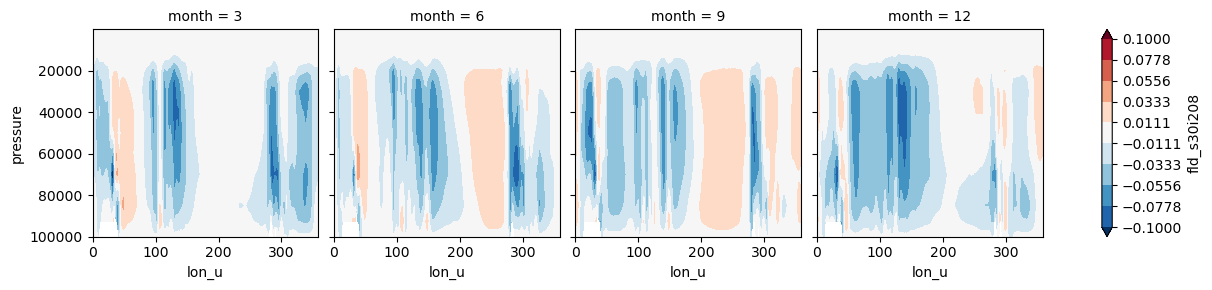

In [55]:
ctrl_om_p.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(col = "month",
                                                                                        levels = 10, vmin = -0.1,
                                                                    extend = "both", col_wrap = 4, yincrease = False)

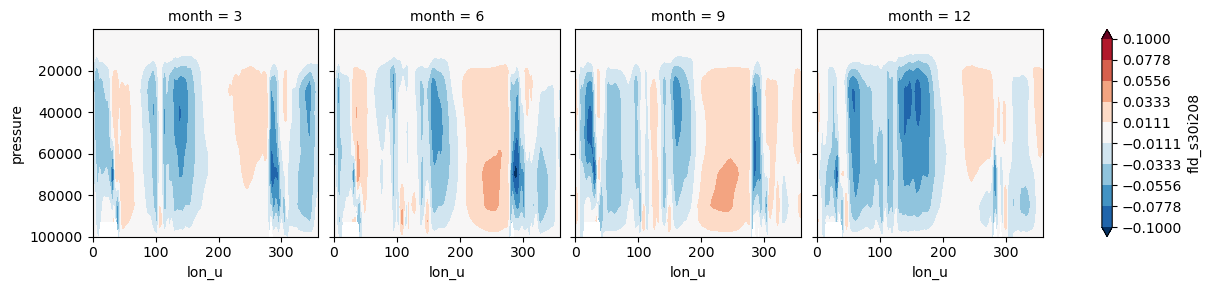

In [56]:
VC_om_p.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v").plot.contourf(col = "month",
                                                                                        levels = 10, vmin = -0.1,
                                                                    extend = "both", col_wrap = 4, yincrease = False)

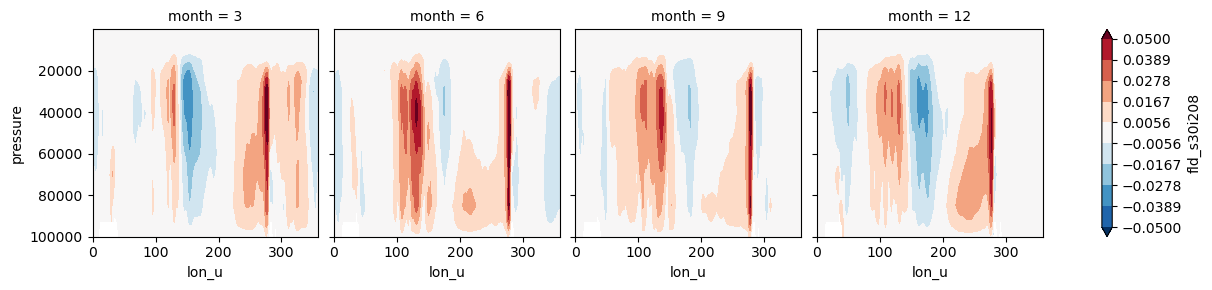

In [57]:
(VC_om_p.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v") - 
 ctrl_om_p.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v")).plot.contourf(col = "month",
                                                                                        levels = 10, vmin = -0.05,
                                                                    extend = "both", col_wrap = 4, yincrease = False)

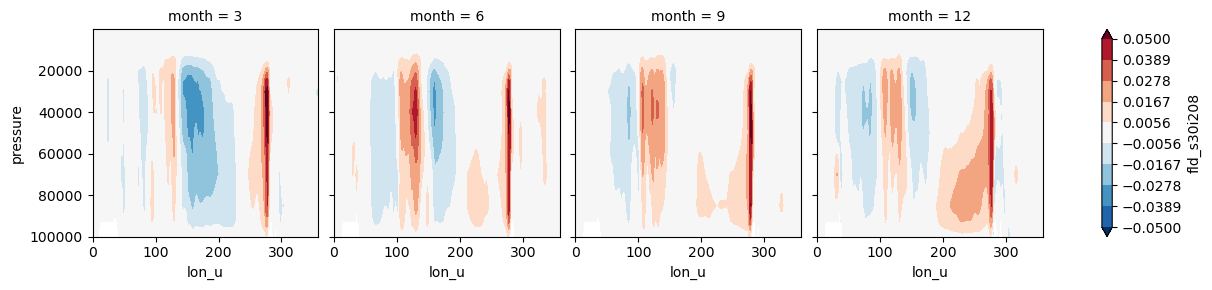

In [58]:
(VC_om_n.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v") - 
 ctrl_om_n.groupby("time.month").mean("time").sel(lat_v = slice(-5,5)).mean("lat_v")).plot.contourf(col = "month",
                                                                                        levels = 10, vmin = -0.05,
                                                                    extend = "both", col_wrap = 4, yincrease = False)

In [59]:
#look at U wind

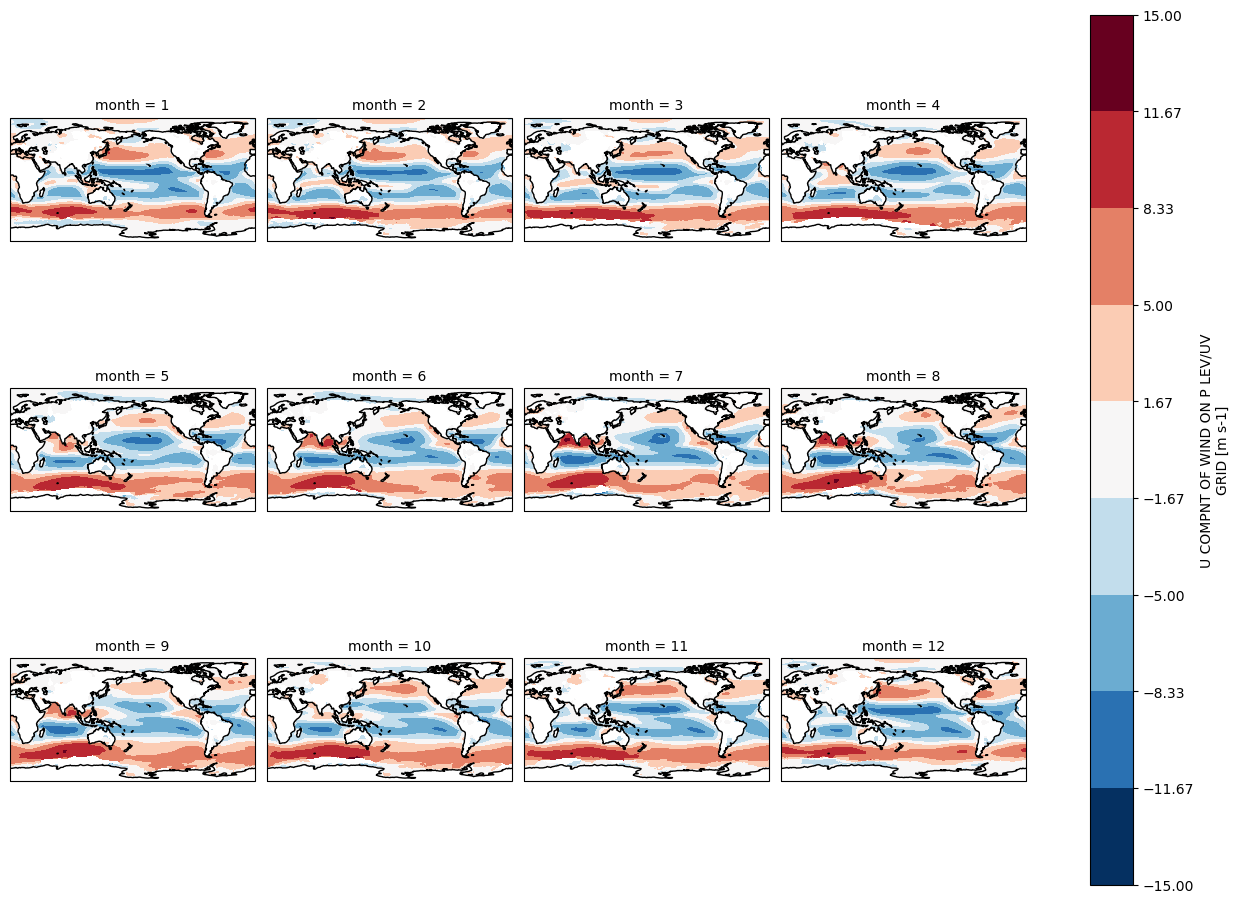

In [68]:
fg = ctrl_uc.sel(pressure = 100000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

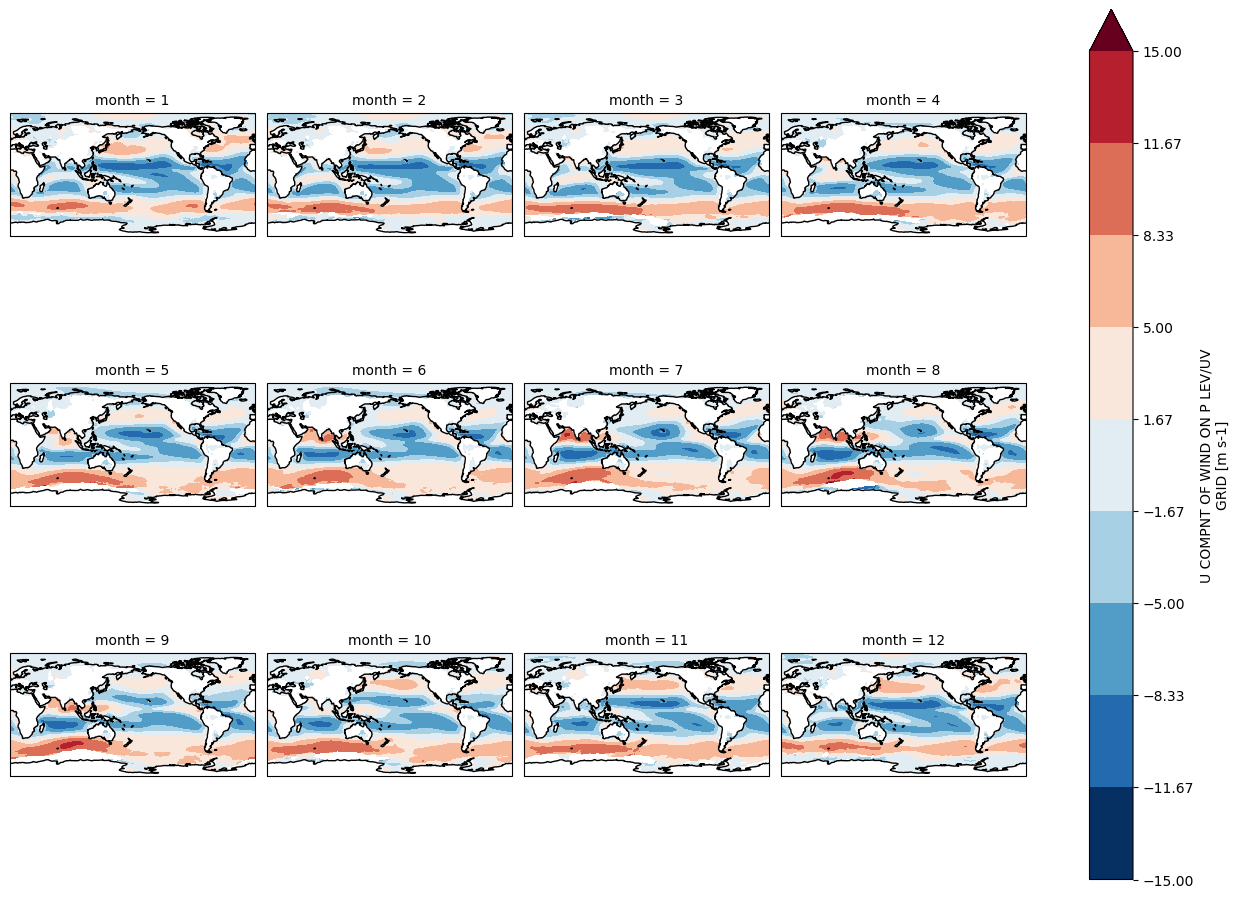

In [70]:
fg = VC_uc.sel(pressure = 100000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

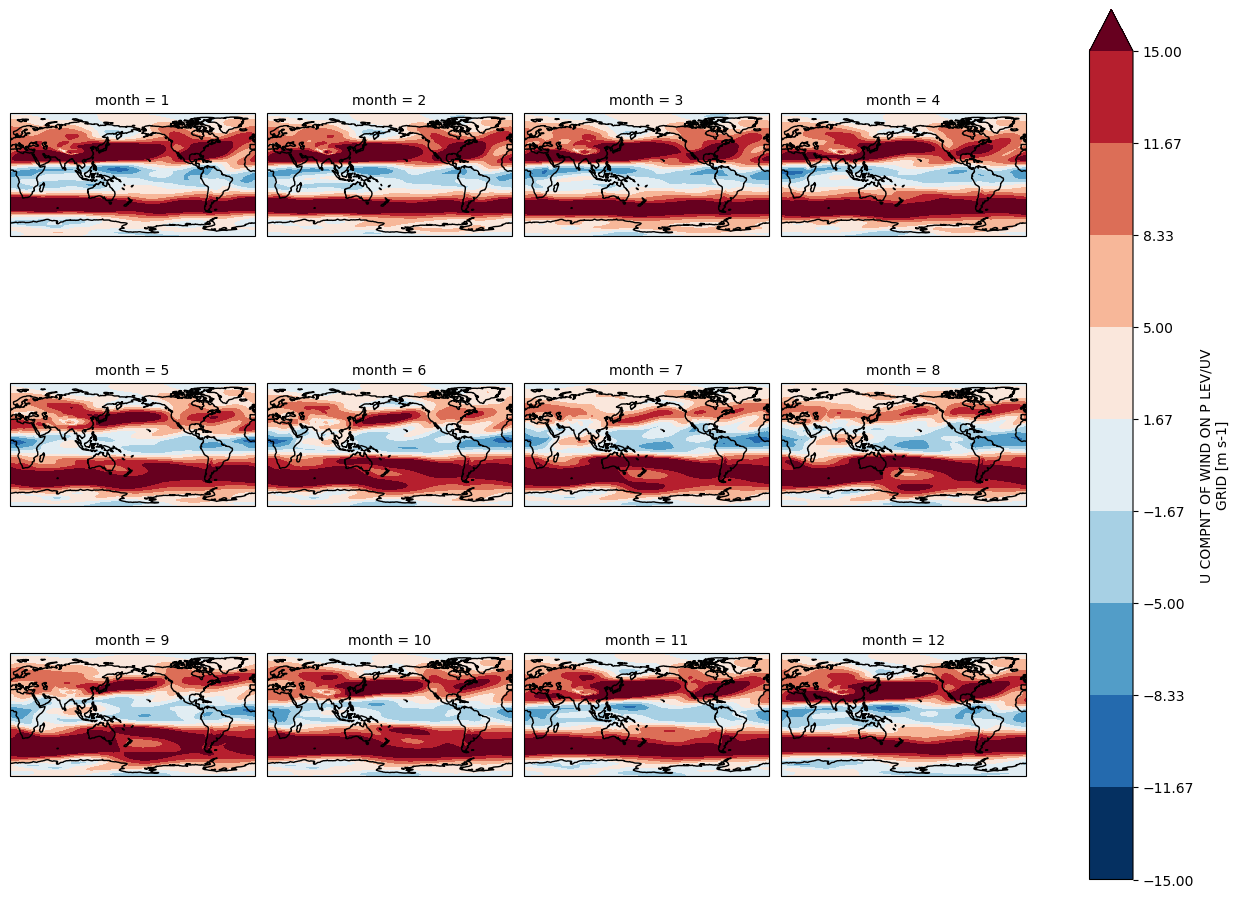

In [71]:
fg = ctrl_uc.sel(pressure = 50000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

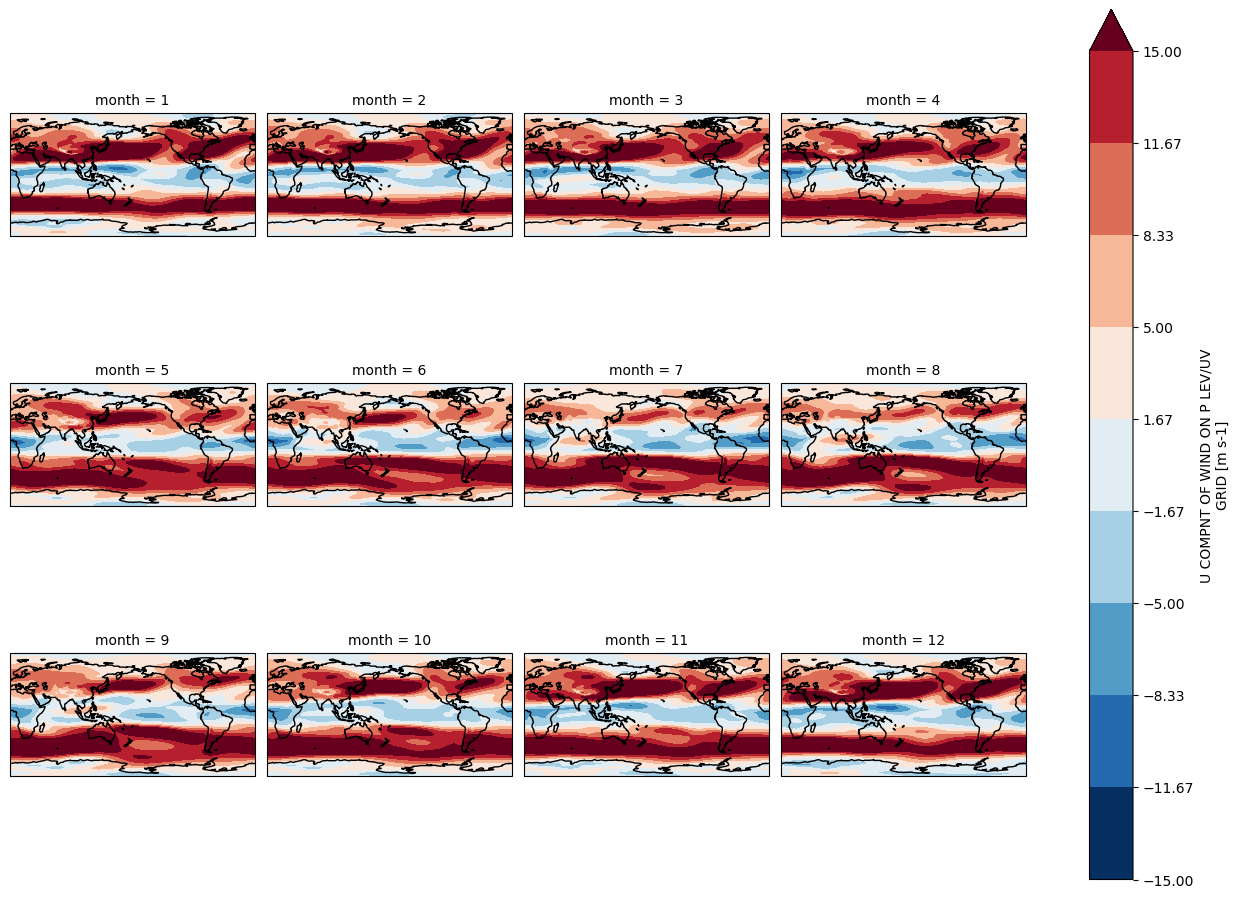

In [72]:
fg = VC_uc.sel(pressure = 50000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

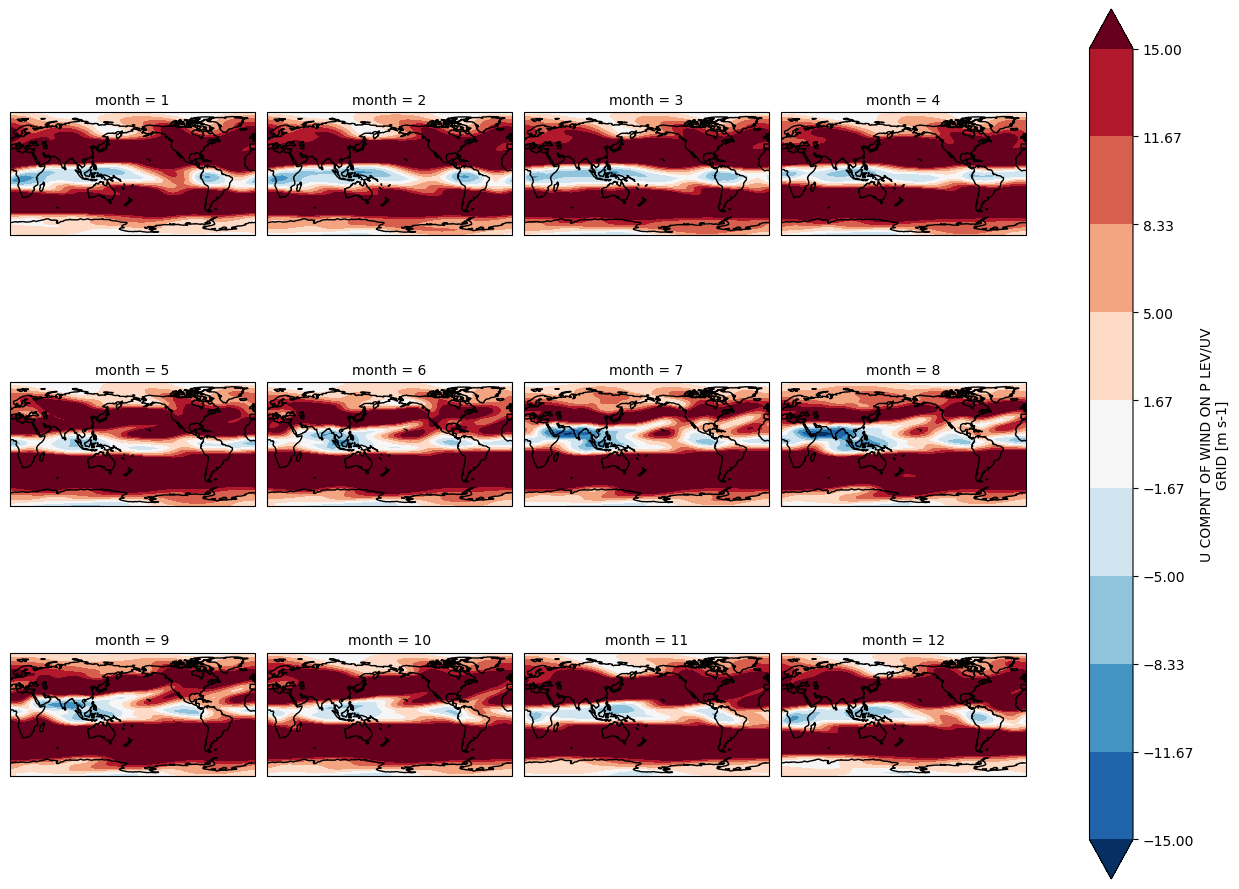

In [73]:
fg = ctrl_uc.sel(pressure = 25000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

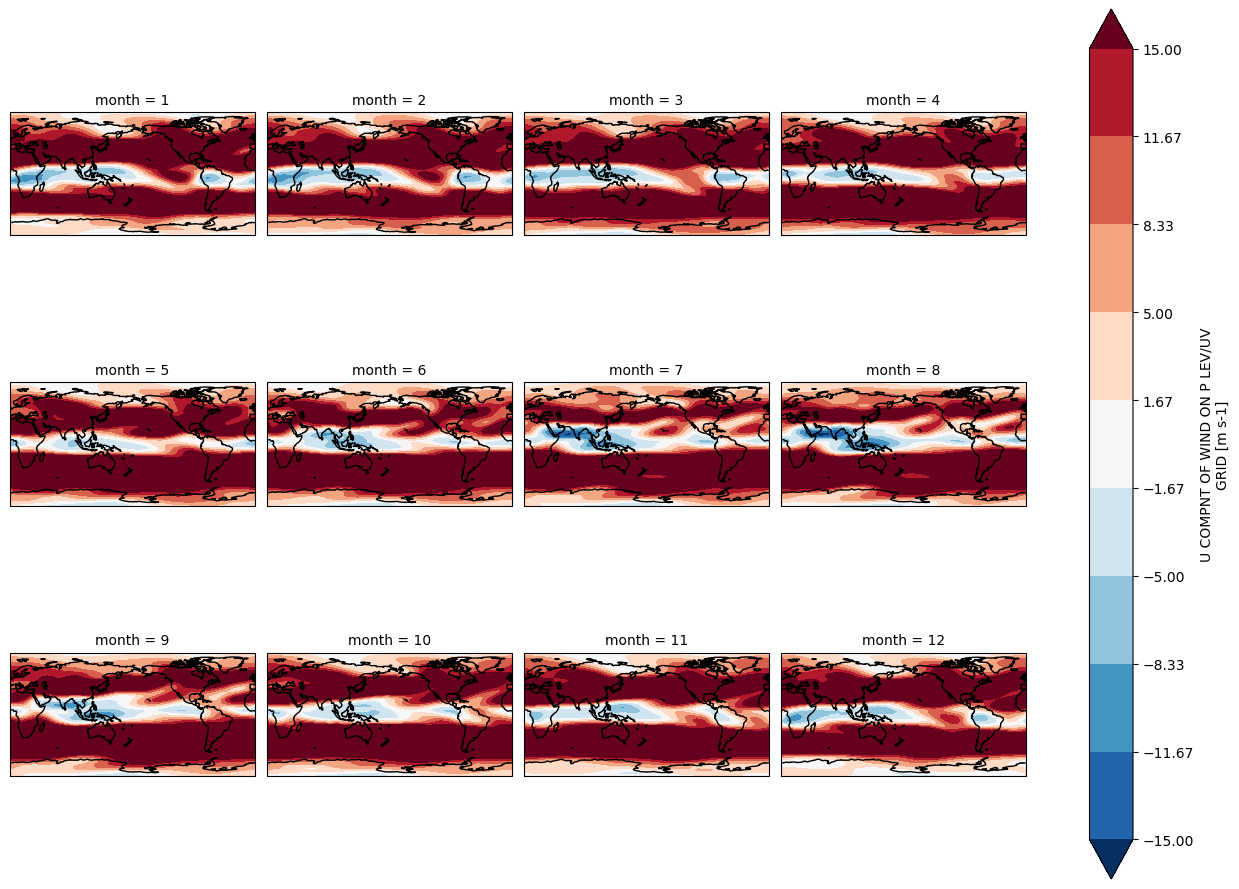

In [74]:
fg = VC_uc.sel(pressure = 25000).plot.contourf(col = "month", col_wrap = 4, vmin = -15, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

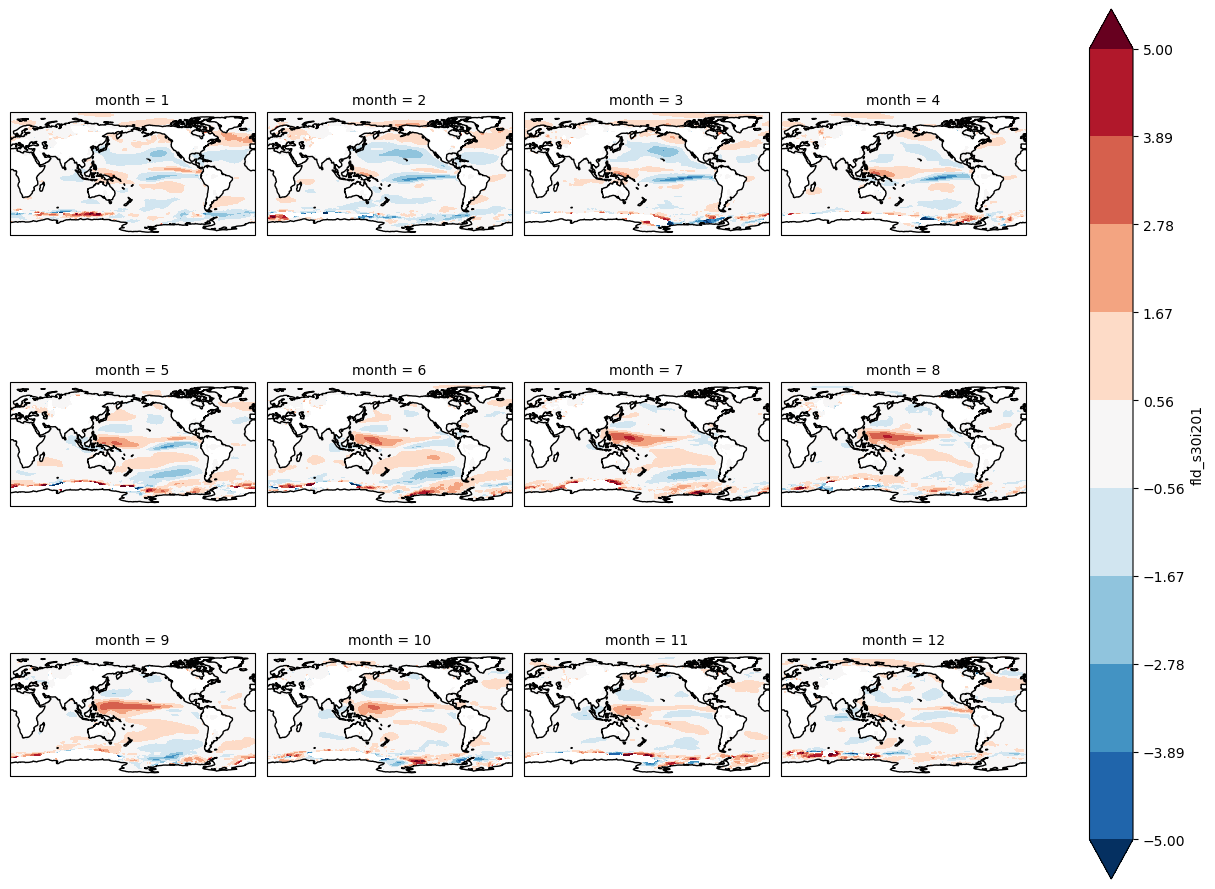

In [76]:
fg = (VC_uc.sel(pressure = 100000)- ctrl_uc.sel(pressure = 100000)).plot.contourf(col = "month", col_wrap = 4, vmin = -5, levels = 10,
                                            transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

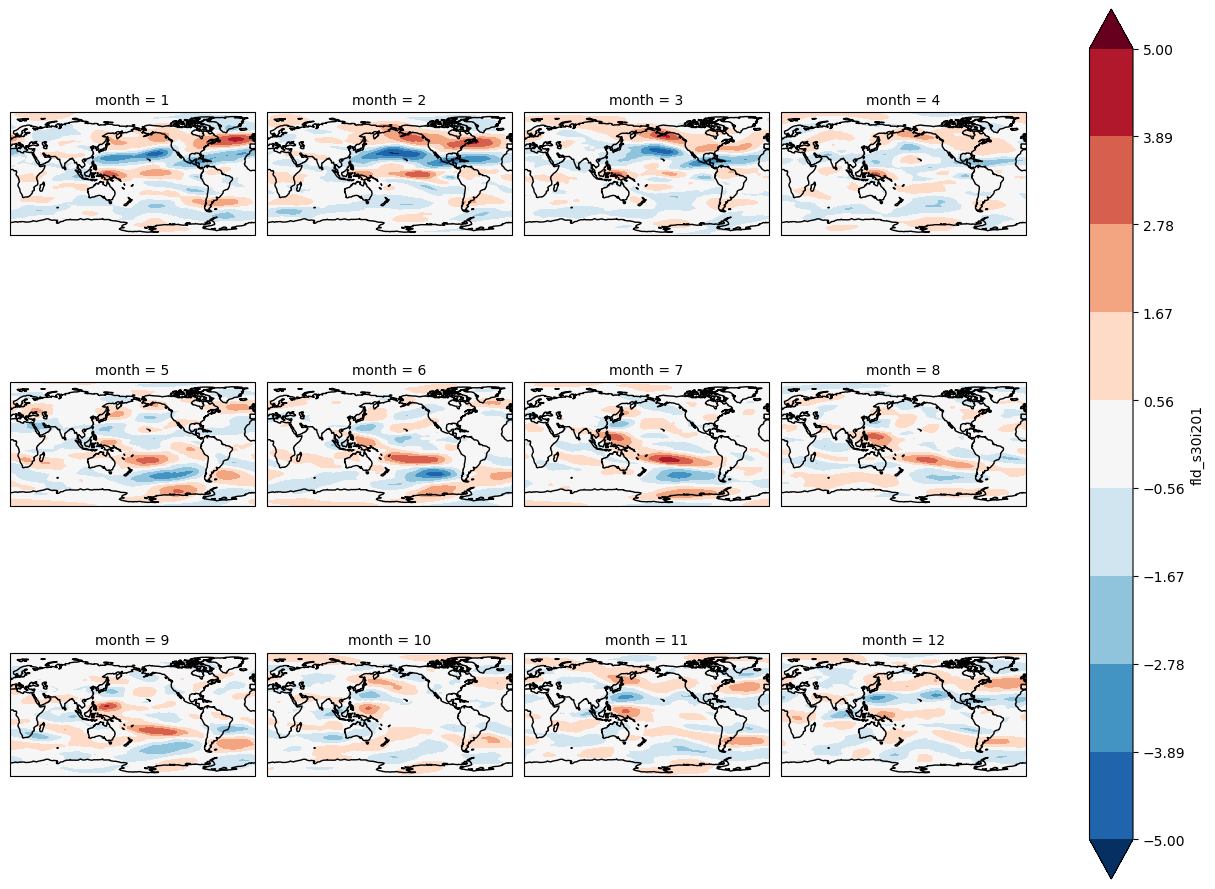

In [78]:
fg = (VC_uc.sel(pressure = 50000)- ctrl_uc.sel(pressure = 50000)).plot.contourf(col = "month", col_wrap = 4, vmin = -5, levels = 10,
                                            extend = "both", transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

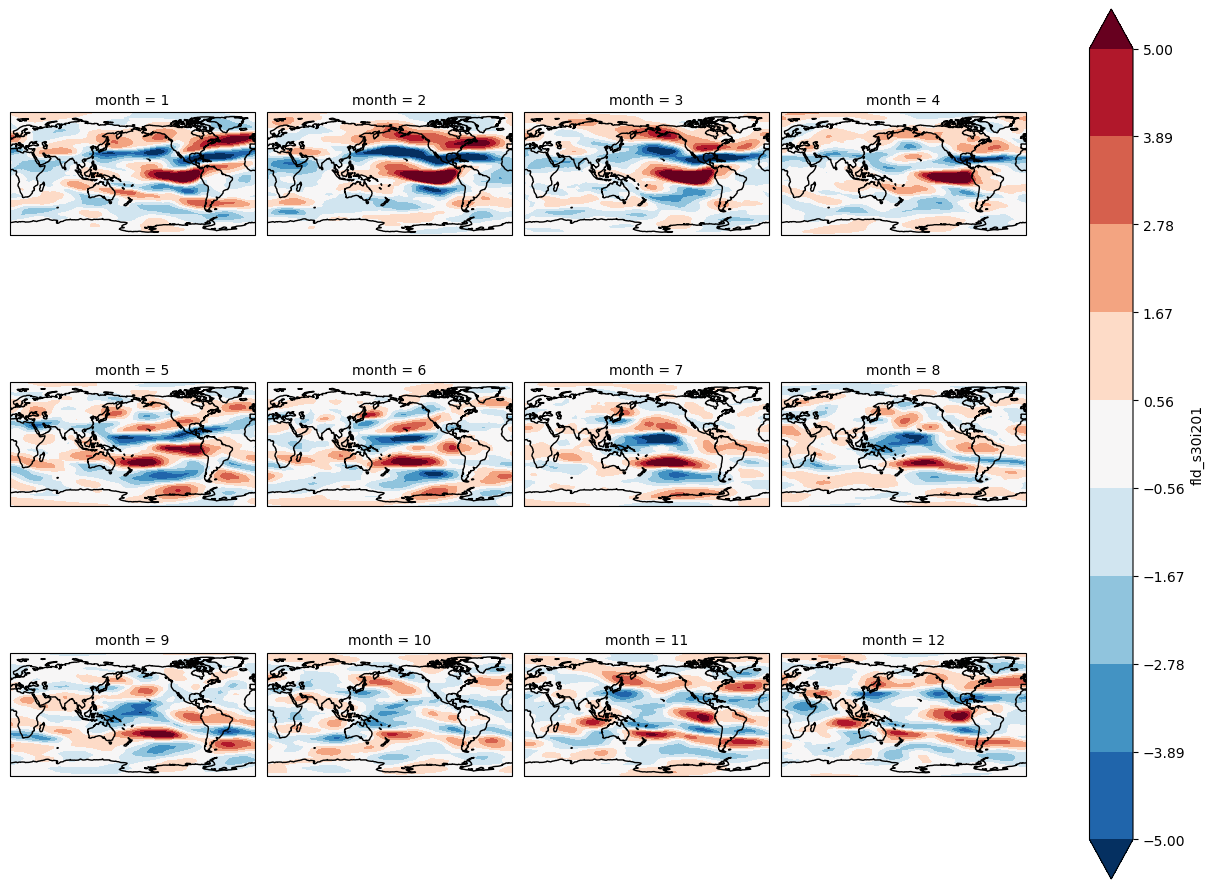

In [79]:
fg = (VC_uc.sel(pressure = 25000)- ctrl_uc.sel(pressure = 25000)).plot.contourf(col = "month", col_wrap = 4, vmin = -5, levels = 10,
                                            extend = "both", transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)})
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()

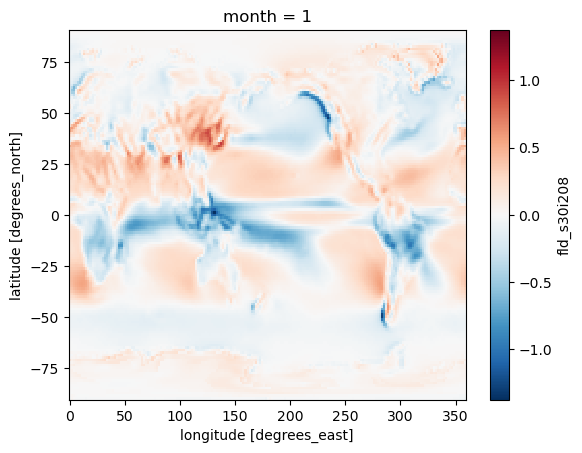

In [41]:
ctrl_omc.sum("pressure")[0].plot()

In [ ]:
ctrl_oms = ctrl_om.groupby("time.month").std("time")
VC_oms = VC_om.groupby("time.month").std("time")
OC_oms = OC_om.groupby("time.month").std("time")

In [ ]:
ctrl_oms = roll_lon(ctrl_oms)
OC_oms = roll_lon(OC_oms)
VC_oms = roll_lon(VC_oms)

In [ ]:
ctrl_omc = roll_lon(ctrl_omc)
OC_omc = roll_lon(OC_omc)
VC_omc = roll_lon(VC_omc)

In [ ]:
ctrl_uc = roll_lon(ctrl_uc)
ctrl_wc = roll_lon(ctrl_wc)


In [ ]:
VC_uc = roll_lon(VC_uc)
VC_wc = roll_lon(VC_wc)

In [ ]:
#plot the zonal win on the 5N5S region
ctrl_u_eq = ctrl_uc.sel(latitude = slice(-5,5)).mean("latitude")
ctrl_w_eq = ctrl_wc.sel(latitude = slice(-1,1)).mean("latitude")
ctrl_om_eq = ctrl_omc.sel(latitude = slice(-1,1)).mean("latitude")

In [ ]:
VC_u_eq = VC_uc.sel(latitude = slice(-5,5)).mean("latitude")


Process Dask Worker process (from Nanny):
2023-10-31 10:02:39,145 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/process.py", line 190, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/nanny.py", line 986, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/asyncio/runners.py", line 47, in run
    _cancel_all_tasks(loop)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-

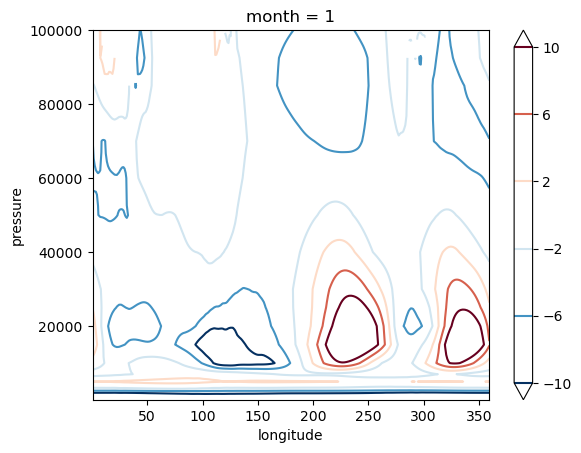

In [179]:
(ctrl_u_eq)[i].plot.contour(levels = [-10,-6,-2,2,6,10], add_colorbar = True)

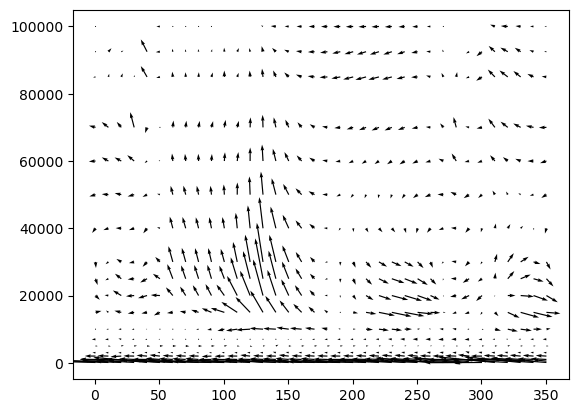

In [181]:
plt.quiver(ctrl_u_eq.longitude.values[::10], ctrl_u_eq.pressure.values, 
              ctrl_u_eq[i,:,::10].values, 1000*ctrl_w_eq[i,:,::10].values)

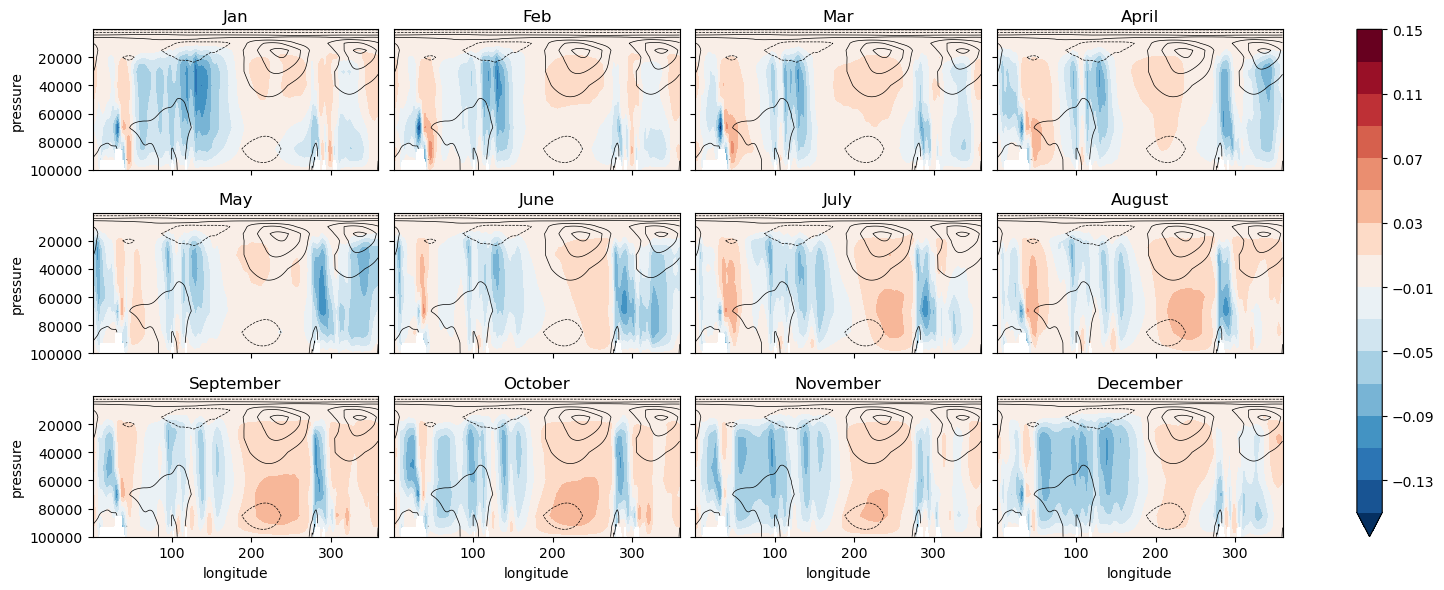

In [189]:
fg = roll_lon(ctrl_omc.sel(latitude = slice(-5,5)).mean("latitude")).plot.contourf(col = "month", 
                                           levels = 16, cmap = "RdBu_r", vmin = -0.15, vmax = 0.15,
                                                     col_wrap = 4, yincrease=False, figsize = (16,6))
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i=0
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    #ax.quiver(ctrl_u_eq.longitude.values[::5], ctrl_u_eq.pressure.values, 
    #          ctrl_u_eq[i,:,::5].values, 1000*ctrl_w_eq[i,:,::5].values)
    ax.contour(ctrl_u_eq.longitude.values, ctrl_u_eq.pressure.values, (ctrl_u_eq)[i].values,
               levels = 10, colors = "k", linewidths = 0.5)
    

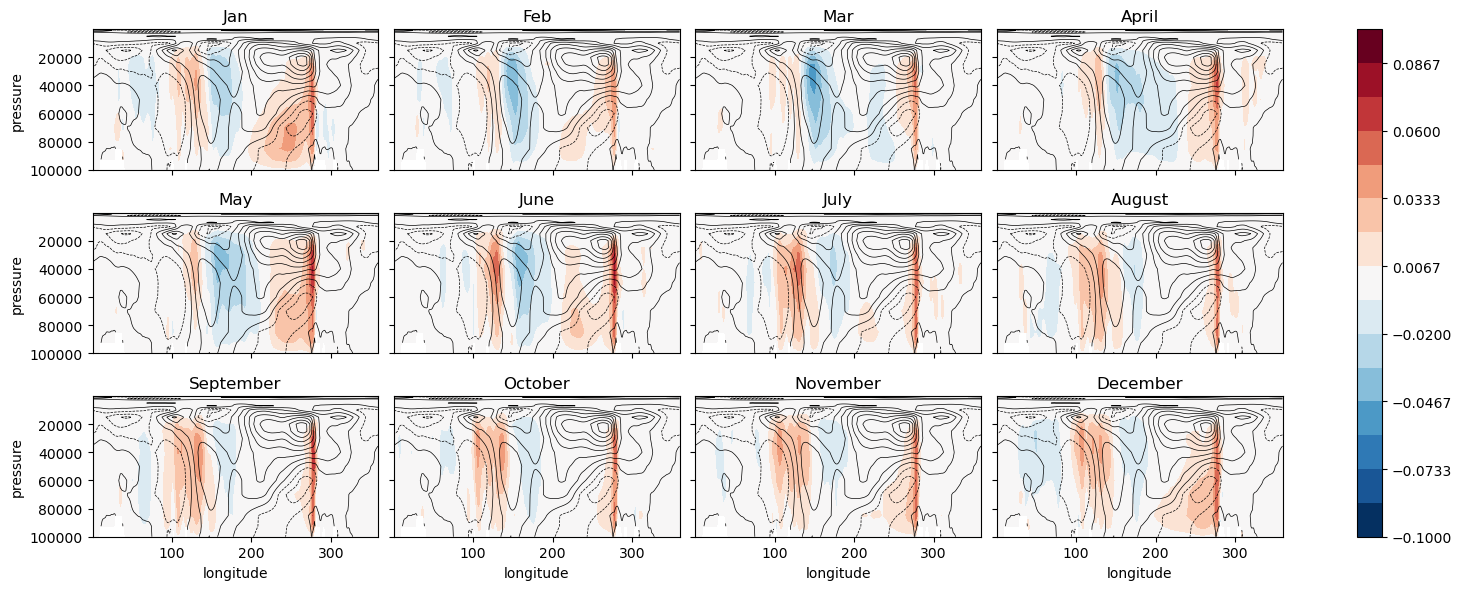

In [188]:
fg = roll_lon(VC_omc.sel(latitude = slice(-5,5)).mean("latitude") - 
    ctrl_omc.sel(latitude = slice(-5,5)).mean("latitude")).plot.contourf(col = "month", 
                                           levels = 16, cmap = "RdBu_r", vmin = -0.1, vmax = 0.1,
                                                     col_wrap = 4, yincrease=False, figsize = (16,6))
titles =["Jan","Feb", "Mar", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i=0
for ax,title in zip(fg.axs.flatten(),titles):
    ax.set_title(title )
    #ax.quiver(ctrl_u_eq.longitude.values[::5], ctrl_u_eq.pressure.values, 
    #          ctrl_u_eq[i,:,::5].values, 1000*ctrl_w_eq[i,:,::5].values)
    ax.contour(ctrl_u_eq.longitude.values, ctrl_u_eq.pressure.values, (VC_u_eq - ctrl_u_eq)[i].values,
               levels = 10, colors = "k", linewidths = 0.5)
    

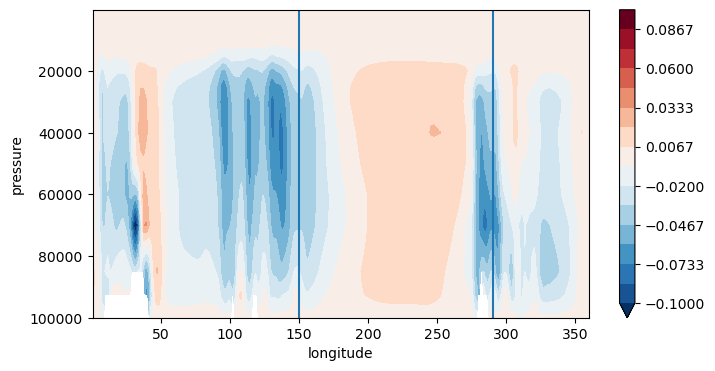

In [190]:
plt.figure(figsize = (8,4))
roll_lon(ctrl_omc.sel(latitude = slice(-5,5)).mean("latitude")).mean("month").plot.contourf(levels = 16, cmap = "RdBu_r", vmin = -0.1, vmax = 0.1,
                                                                      yincrease=False)
plt.axvline(150)
plt.axvline(290)

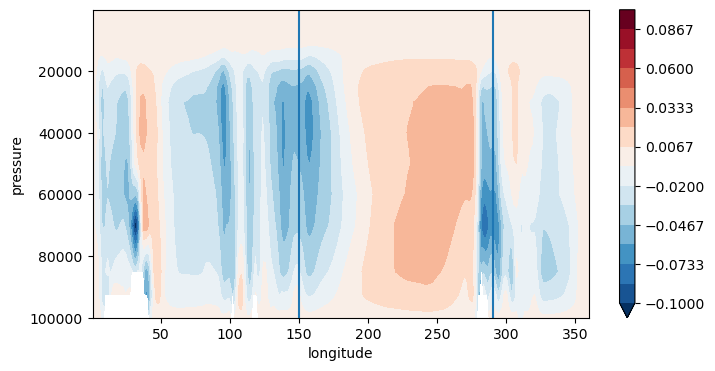

In [191]:
plt.figure(figsize = (8,4))
roll_lon(VC_omc.sel(latitude = slice(-5,5)).mean("latitude")).mean("month").plot.contourf(levels = 16, cmap = "RdBu_r", vmin = -0.1, vmax = 0.1,
                                                                      yincrease=False)
plt.axvline(150)
plt.axvline(290)

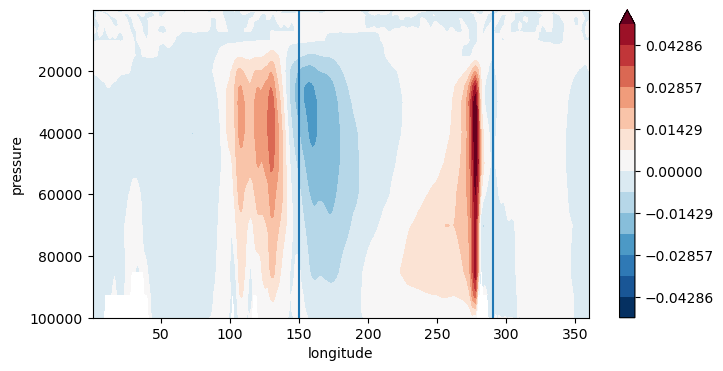

In [225]:
plt.figure(figsize = (8,4))
roll_lon((VC_omc - ctrl_omc).sel(latitude = slice(-5,5)).mean("latitude")).mean("month").plot.contourf(levels = 15, cmap = "RdBu_r", vmin = -0.05, vmax = 0.05,
                                                                      yincrease=False)
plt.axvline(150)
plt.axvline(290)

In [217]:
#create surface level wind biasvars
VC_bu = VC_u.sel(pressure =100000) - ctrl_u.sel(pressure =100000)

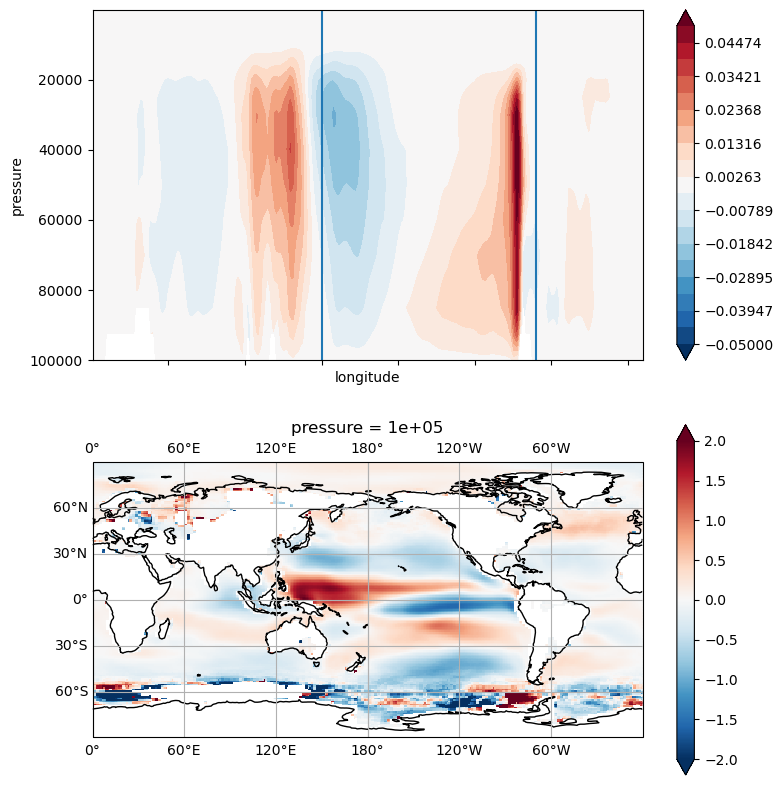

In [229]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plot the first subplot
ax1 = plt.subplot(2, 1, 1)
roll_lon((VC_omc - ctrl_omc).sel(latitude=slice(-5, 5)).mean("latitude")).mean("month").plot.contourf(
    levels=20, cmap="RdBu_r", vmin=-0.05, vmax=0.05, yincrease=False, extend = "both")
plt.axvline(150)
plt.axvline(290)

# Plot the second subplot with Cartopy
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
VC_bu.mean("time").plot(vmin = -2, transform = ccrs.PlateCarree())
#ax2.set_extent([], crs=ccrs.PlateCarree)
ax2.coastlines()

# Add gridlines
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Show the plot
plt.tight_layout()
plt.show()

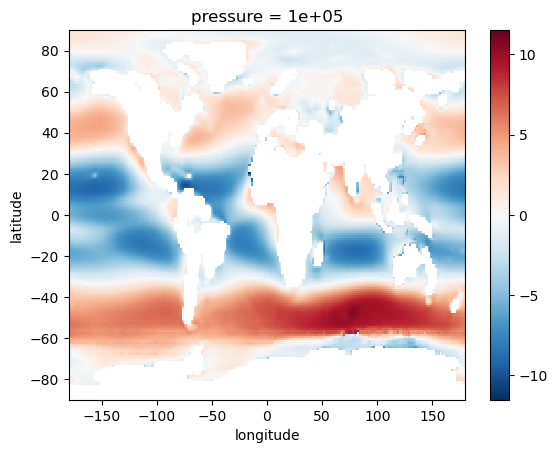

In [223]:
ctrl_u.sel(pressure =100000).mean("time").plot()

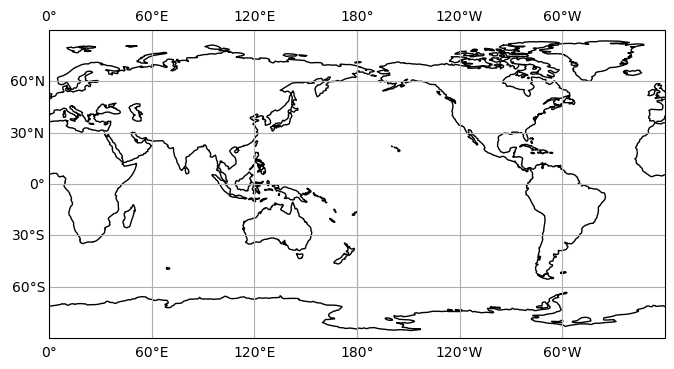

In [200]:
fig, ax = plt.subplots(figsize = (8,4),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})
ax.coastlines()
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)


In [ ]:
#lets look at u wind strength
(VC_uc-ctrl_uc).sel(pressure = 100000).plot(col = "month", col_wrap = 4)

In [13]:
#define index for southern osicalliation index
def SOI(psl):
    #psl =  (psl.groupby('time.month')- psl.groupby('time.month').mean("time")).drop("month")
    east = psl.sel(longitude = slice(360-130, 360-80), latitude =slice(-5,5)).mean(['latitude', 'longitude'])
    west = psl.sel(longitude = slice(90,140), latitude =slice(-5,5)).mean(['latitude', 'longitude'])
    return east-west

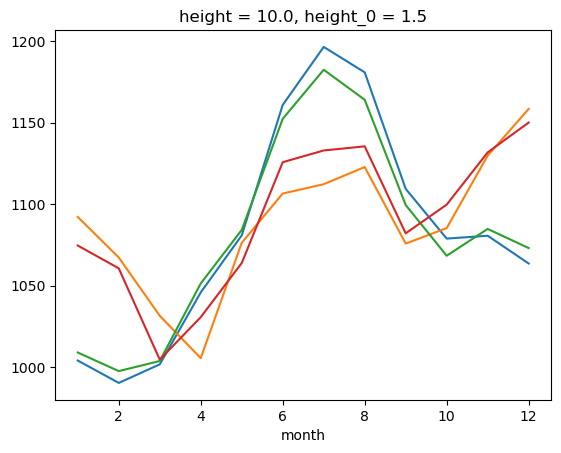

In [14]:
SOI(ctrl_psl).groupby('time.month').mean("time").plot()
SOI(OC_psl).groupby('time.month').mean("time").plot()
SOI(MC_psl).groupby('time.month').mean("time").plot()
SOI(VC_psl).groupby('time.month').mean("time").plot()

In [46]:
#load in u v om from one exp.
VC_u = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_u/VC_u*.nc",
                          use_cftime=True)

In [47]:
#load in u v om from one exp.
VC_v = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_v/VC_v*.nc",
                          use_cftime=True, chunks= {"time":120})

In [48]:
#load in u v om from one exp.
VC_om = xr.open_mfdataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VC_om/VC_om*.nc",
                          use_cftime=True, chunks= {"time":240})

In [49]:
VC_u = VC_u.fld_s30i201
VC_v = VC_v.fld_s30i202
VC_om = VC_om.fld_s30i208


In [56]:
VC_u

<xarray.DataArray 'fld_s30i201' (time: 360, pressure: 19, lat_v: 145, lon_u: 192)>
dask.array<concatenate, shape=(360, 19, 145, 192), dtype=float32, chunksize=(12, 19, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0951-01-16 12:00:00 ... 0980-12-16 12:00:00
  * lon_u     (lon_u) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat_v     (lat_v) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * pressure  (pressure) float64 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
Attributes:
    standard_name:    eastward_wind
    long_name:        U COMPNT OF WIND ON P LEV/UV GRID
    units:            m s-1
    um_stash_source:  m01s30i201
    cell_methods:     time: mean
    grid_mapping:     latitude_longitude

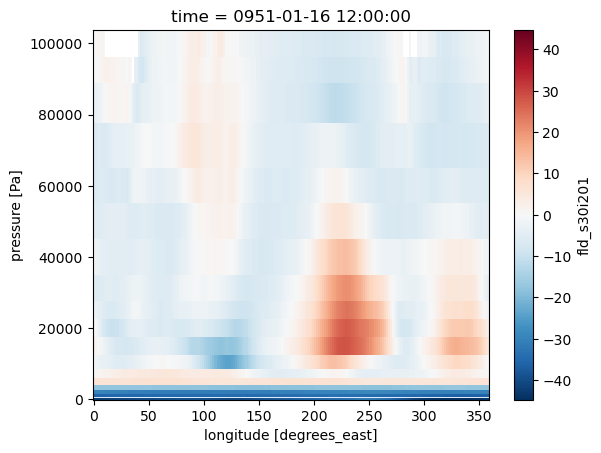

In [54]:
VC_u.sel(lat_v = slice(-5,5)).mean("lat_v")[0].plot()

In [3]:
test = xr.open_mfdataset("/scratch/e14/sm2435/PACE_OC/cw323/history/atm/netCDF/cw323a.pm095512_mon.nc",
                         use_cftime=True, chunks= {"time":12})

In [4]:
omega = test.fld_s30i208

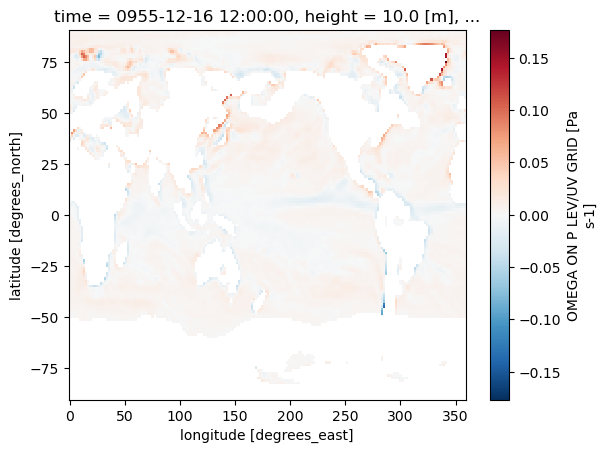

In [5]:
omega[0,0].plot()

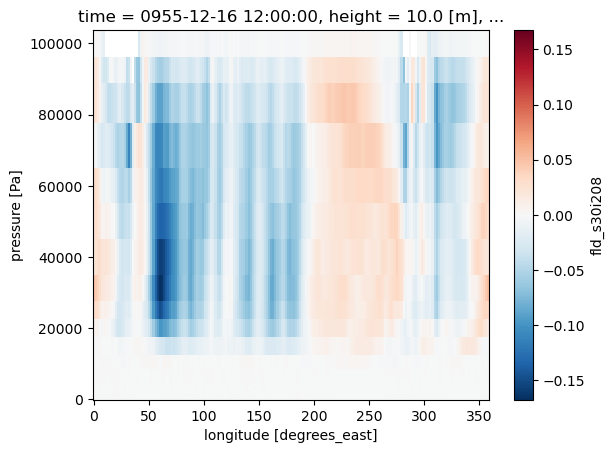

In [6]:
omega[0].sel(lat_v = slice(-5,5)).mean("lat_v").plot()

In [5]:
zg = xr.open_dataset("/scratch/e14/sg7549/seb_final/cw323/v1.0/mon/zg_ACCESS-CM2_cw323a_mon_095101-100912.nc",
                     use_cftime=True, chunks= {"time":12})

In [7]:
zg = zg.zg

In [31]:
zga = (zg.groupby('time.month') - zg.groupby("time.month").mean("time")).drop("month")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]


In [32]:
zga

<xarray.DataArray 'zg' (time: 708, plev: 19, lat: 144, lon: 192)>
dask.array<sub, shape=(708, 19, 144, 192), dtype=float32, chunksize=(1, 19, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0951-01-16 12:00:00 ... 1009-12-16 12:00:00
  * plev     (plev) float64 100.0 500.0 1e+03 2e+03 ... 8.5e+04 9.25e+04 1e+05
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

In [15]:
#make pressures go from 1000 hPa to 100 hPa
zg = zg.sel(plev=slice(None, None, -1))

In [18]:
zg

<xarray.DataArray 'zg' (time: 708, plev: 19, lat: 144, lon: 192)>
dask.array<getitem, shape=(708, 19, 144, 192), dtype=float32, chunksize=(12, 19, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0951-01-16 12:00:00 ... 1009-12-16 12:00:00
  * plev     (plev) float64 100.0 500.0 1e+03 2e+03 ... 8.5e+04 9.25e+04 1e+05
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    comment:        Geopotential is the sum of the specific gravitational pot...
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2023-10-10T23:54:38Z altered by CMOR: replaced missing va...

In [33]:
equator = zga.sel(lat = slice(-5,5)).mean("lat")

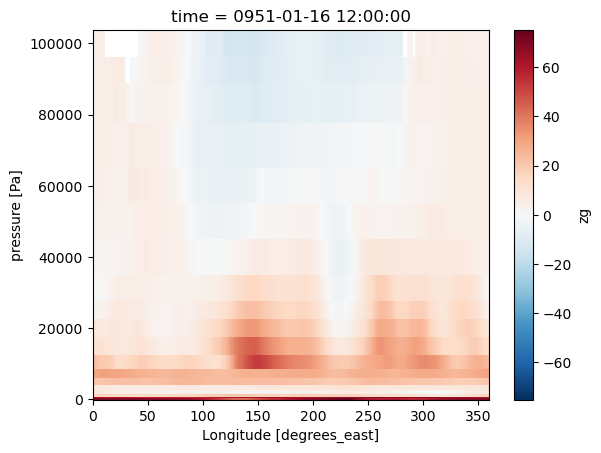

In [34]:
equator[0].plot()

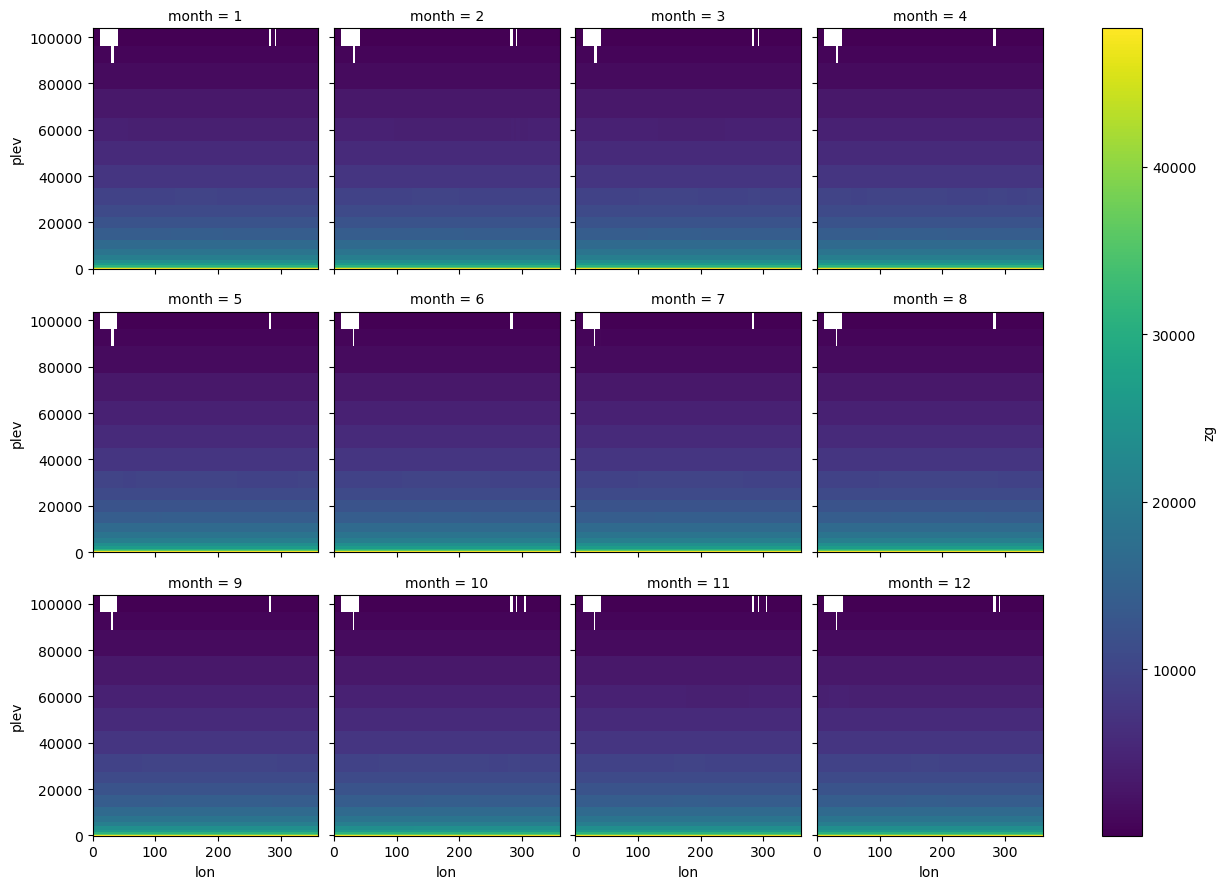

In [19]:
equator.groupby("time.month").mean("time").plot(col = 'month', col_wrap = 4)

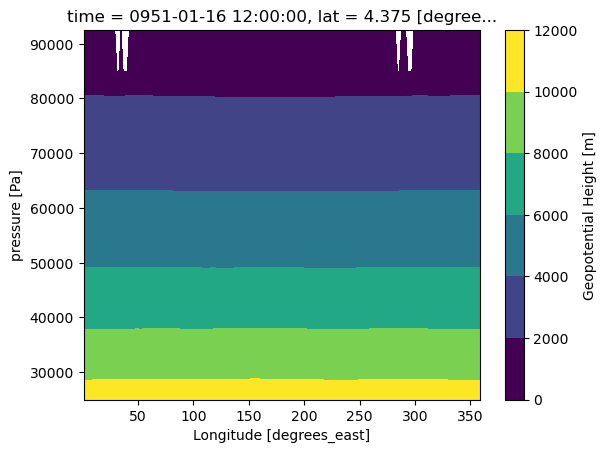

In [30]:
zg[0,10:-1, 75].plot.contourf()